In [1]:
'''
Importing needed modules and frameworks
'''
import pandas as pd
import pywt
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

WAVELET TRANSFORM

In [2]:
'''
Preprocessing: Use wavelet transform as a feature for traning our model
In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc
'''
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    #compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

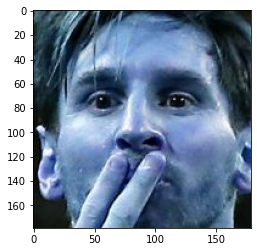

In [3]:
cr_img = cv2.imread('./dataset/cropped/lionel_messi/lionel_messi1.png')
plt.imshow(cr_img)

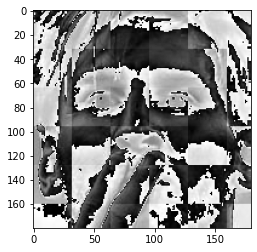

In [4]:
im_har = w2d(cr_img,'db1',5)
plt.imshow(im_har, cmap='gray')

In [5]:
with open('celebrity_file_names_dict.json', 'r') as f:
    celebrity_file_names_dict = json.load(f)
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict


{'cropped': 0,
 'lionel_messi': 1,
 'maria_sharapova': 2,
 'roger_federer': 3,
 'serena_williams': 4,
 'virat_kohli': 5}

In [6]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(168, 4096)

Data cleaning, processing and feature engineering processes are complete. Now we are ready to train our model
We will use SVM with rbf kernel tuned with heuristic finetuning

In [7]:
#Splitting the data into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [21]:
my_pipeline = Pipeline([('scaler', StandardScaler()), ('svc', svm.SVC(kernel = 'rbf', C = 10))])
my_pipeline.fit(X_train, y_train)
my_pipeline.score(X_valid, y_valid)

0.8809523809523809

In [22]:
print(classification_report(y_valid, my_pipeline.predict(X_valid)))

              precision    recall  f1-score   support

           1       0.83      0.71      0.77         7
           2       0.91      1.00      0.95        10
           3       0.86      0.86      0.86         7
           4       0.75      0.86      0.80         7
           5       1.00      0.91      0.95        11

    accuracy                           0.88        42
   macro avg       0.87      0.87      0.87        42
weighted avg       0.89      0.88      0.88        42



In [8]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [9]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.833538,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.635077,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.826154,{'logisticregression__C': 1}


In [25]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [26]:
for algo in model_params.keys():
    print(algo, best_estimators[algo].score(X_valid, y_valid))

svm 0.9285714285714286
random_forest 0.8095238095238095
logistic_regression 0.9285714285714286


In [10]:
best_clf = best_estimators['svm']

In [12]:
joblib.dump(best_clf, './backend/utilities/saved_model.pkl')
with open("./backend/utilities/class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))